# Redes Neurais para Previsão de Trajetória

Neste notebook, usaremos redes neurais para previsão de trajetória futura de uma tempestade. A ideia geral é dado as informações de um furacão de algumas horas atrás e do presente, projetaremos a sua posição futura. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
%matplotlib inline

In [5]:
import tensorflow as tf

tf.keras.backend.clear_session()  

print(tf.__version__)

2.0.0


## Preparação dos dados

Iremos abaixo criar funções para preparar nossos dados para o modelo, e aplicá-las ao dataframe original

In [6]:
#Leitura dos dados
data = pd.read_csv('Datasets/data_atl_merged2.csv',parse_dates=['Date'])
data.columns

Index(['ID', 'Name', 'Date', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'Minimum Pressure', 'Date_c', 'Year',
       'Month', 'Day', 'Latitude_c', 'Longitude_c', 'Duration', 'sst', 'rhum',
       'wspd', 'slp', 'cldc'],
      dtype='object')

# Parte que vou retirar depois (Alysson, se quiser copie isso por seu jupyter)

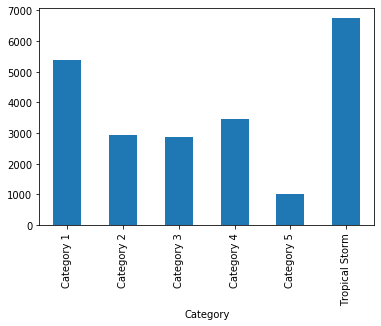

In [6]:
data = data[['ID', 'Name', 'Date','Year', 'Time', 'Event', 'Status', 'Latitude',
       'Longitude', 'Maximum Wind', 'sst', 'rhum',
       'wspd', 'slp', 'cldc']]
def category(mw):
    if mw>=137:
        return "Category 5"
    elif mw>=113:
        return "Category 4"
    elif mw>=96:
        return "Category 3"
    elif mw>=83:
        return "Category 2"
    elif mw>=64:
        return "Category 1"
    elif mw>=34:
        return "Tropical Storm"
    else:
        return "Tropical Depression"
cat_id = data.groupby('ID')['Maximum Wind'].max().apply(category)
data.loc[:,'Category']=data.ID.apply(lambda x:cat_id[x])
data.groupby('Category')['ID'].count().plot.bar();

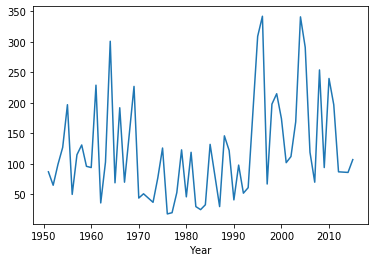

In [7]:

major_df = data[data.Category.apply(lambda x: 0 if x[-1]=='m' else int(x[-1]))>=3]
major_df.groupby('Year')['ID'].count().plot()
#Major Hurricanes by Year

In [8]:
data

,ID,Name,Date,Year,Time,Event,Status,Latitude,Longitude,Maximum Wind,sst,rhum,wspd,slp,cldc,Category
0,AL011951,UNNAMED,1951-01-02,1951,1200,NaN,EX,30.5,-58.0,50,12.371029,72.457094,72.457094,1027.446055,5.219256,Tropical Storm
1,AL011951,UNNAMED,1951-01-02,1951,1800,NaN,EX,29.9,-56.8,45,16.217764,80.423854,80.423854,1022.672978,5.756614,Tropical Storm
2,AL011951,UNNAMED,1951-01-03,1951,0,NaN,EX,29.0,-55.7,45,15.491124,81.121590,81.121590,1023.151909,5.782474,Tropical Storm
3,AL011951,UNNAMED,1951-01-03,1951,600,NaN,EX,27.5,-54.8,45,22.268075,84.264761,84.264761,1019.325138,5.651842,Tropical Storm
4,AL011951,UNNAMED,1951-01-03,1951,1200,NaN,EX,26.5,-54.5,45,22.336746,84.458617,84.458617,1019.305866,5.645406,Tropical Storm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22381,AL122015,KATE,2015-11-12,2015,1200,NaN,EX,41.3,-50.4,55,8.150870,58.920257,58.920257,1025.728740,5.537978,Category 1
22382,AL122015,KATE,2015-11-12,2015,1800,NaN,EX,41.9,-49.9,55,8.182679,59.034473,59.034473,1025.715564,5.542256,Category 1
22383,AL122015,KATE,2015-11-13,2015,0,NaN,EX,41.5,-49.2,50,7.611888,57.003590,57.003590,1025.944601,5.473615,Category 1
22384,AL122015,KATE,2015-11-13,2015,600,NaN,EX,40.8,-47.5,45,8.666978,83.324036,83.324036,1025.446874,6.021198,Category 1


# Fim da parte de vou retirar

In [9]:
# from math import sin, cos, sqrt, tan, atan2, radians, log, pi, degrees
# def direction(lat1,lon1,lat2,lon2):
#     lat1 = radians(lat1)
#     lat2 = radians(lat2)
#     lon1 = radians(lon1)
#     lon2 = radians(lon2)
#     d_phi = log(tan(lat2/2 + pi/4)/tan(lat1/2 + pi/4))
#     dlon = abs(lon1 - lon2)%180
#     d = atan2(dlon, d_phi) 

#     return degrees(d)

In [10]:
# for i in range(1,len(data)):
#     data.loc[i,'Dir'] = direction(data.loc[i,'Latitude'],data.loc[i,'Longitude'],
#                                   data.loc[i-1,'Latitude'],data.loc[i-1,'Latitude'])
# data.Dir.hist(bins = 10)

In [11]:
# data_coords = data.copy()
# for i in range(len(data_coords)-1):
#     if abs(data_coords.loc[i+1,'Time']-data_coords.loc[i,'Time'])%600!=0:
#         if data_coords.loc[i+1,'ID']==data_coords.loc[i,'ID']:
#             print(i,data_coords.loc[i+1,'Time']-data_coords.loc[i,'Time'])

In [10]:
## Funções de Normalização e Padronização:
def min_max_scale(data,cols):
    df = data.copy()
    for col in cols:
        min_ = df[col].min()
        max_ = df[col].max()
        df.loc[:,col] = (df[col]-min_)/(max_-min_)
    return df[cols]
def standard_scale(data,cols):
    df = data.copy()
    for col in cols:
        mean = df[col].mean()
        std = df[col].std()
        df.loc[:,col] = (df[col]-mean)/std
    return df[cols]
def standard_scale_back(scaled,original,cols):
    df = scaled.copy()
    for col in cols:
        mean = original[col].mean()
        std = original[col].std()
        df.loc[:,col] = df[col]*std+mean
    return df[cols]

In [20]:
def split(df):
    st = []
    ids = df.ID.unique()
    for ID in ids:
        st.append(df[df.ID==ID])
    return st
splitted = split(data)
print(len(splitted))

685


A função "clean_data" formata o preditor Tempo, o convertendo para horas (por padrão, horas após Jan/1951), e padroniza os dados de input.

A função "shift_data", faz um shift dos dados e dá como saída as matriz tridimensional X e o vetor Y, onde X é composto por matrizes $s\times n$:

$$\left[\begin{matrix}
x_1^{(t-s+1)} & x_2^{(t-s+1)} & ...& x_n^{(t-s+1)}\\
x_1^{(t-s+2)} & x_2^{(t-s+2)} & ...& x_n^{(t-s+2)}\\
\vdots &\vdots &\vdots &\vdots\\
x_1^{(t)} & x_2^{(t)} & ...& x_n^{(t)}\end{matrix}\right]$$

na qual:

- $x_1,~x_2, ~..., ~x_n$ representam os $n$ preditores usados (Usaremos 4 inicialmente: tempo latitude, longitude e velocidade de vento)

- $x_i^{(k)}$ representa o preditor $i$ no registro de tempo $k$. 

- $s$ é o parâmetros "shift", que representa em quantos períodos passados basearemos a previsão futura. Por padrão, inicialmente, deixamos $s=3$. Como cada registro é espaçado por 6 horas, neste formado estamos usando daados do presente e de 12 horas atrás, pra projetar o dado futuro.

O vetor $Y$ é composto por:

$$\left[\begin{matrix}lat^{(t+1)}&lon^{(t+1)}\\
lat^{(t+2)}&lon^{(t+2)}\\
\vdots & \vdots\\
lat^{(t+p)}&lon^{(t+p)}\end{matrix}\right]$$

na qual:

- $lat^{(k)}$ e $lon^{(k)}$ representam latitude e longitude no registro de tempo $k$
- $p$ é o parâmetro "pred", que diz quantos períodos à frente iremos prever. Por padrão, deixamos $p=1$, assim a matriz se resume em um vetor $[lat^{(t+1)},~ lon^{(t+1)}]$



In [17]:
input_cols = ['Hours','Latitude','Longitude','Maximum Wind']
data.loc[:,'Time_new']=data.Date+data.Time.map(lambda x: pd.Timedelta(hours=x/100))

def clean_data(df,input_cols = input_cols, year0 = 1951):
    df2 = df.copy()
    df2.loc[:,'Hours'] = (df2.loc[:,'Time_new']-pd.Timestamp(year0,1,1))/pd.Timedelta('1 hour')
    df2.loc[:,input_cols] = standard_scale(df2,input_cols)
    return df2[['ID']+input_cols]

def shift_data(df,shift = 3,pred = 1):

    x = []
    y = []
    df = df.set_index(np.arange(0,len(df)))
    for i in range(0,len(df)-shift):
        x_arr = []
        for j in range(i,i+shift):
            x_arr.append(df.loc[j,:])
        y.append(np.array(df.loc[i+shift:i+shift+pred-1,['Latitude','Longitude']]).ravel())
        x.append(np.array(x_arr))
       
    return np.array(x),np.array(y)

In [18]:
data_cleaned = clean_data(data)
data_cleaned.describe()

,Hours,Latitude,Longitude,Maximum Wind
count,2.238600e+04,2.238600e+04,2.238600e+04,2.238600e+04
mean,-1.312271e-17,3.398752e-15,4.449279e-15,5.249630e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.823465e+00,-1.939104e+00,-2.303286e+00,-1.644750e+00
25%,-8.725997e-01,-8.005268e-01,-7.741070e-01,-8.529203e-01
50%,1.595638e-01,-4.466462e-02,-5.884587e-02,-2.590479e-01
75%,9.229854e-01,6.250867e-01,7.057436e-01,5.327820e-01
max,1.499554e+00,5.121988e+00,6.195990e+00,4.491932e+00


### Treino, Validação e Teste

Para formatar os dados de treino, teste e validação, primeiramente, usamos a função "split", que separa os dados em uma lista de dataframes onde cada um deles representa uma tempestade diferente.

Após isso atribuimos 70% da lista para treino, 20% para validação e 10% para teste. Cada dataframe é devidamente formatado para as matrizes acima usando a função "shift_data", e após isso, unimos as matrizes de saída para gerar a numpy array final, do modelo.

Se fizéssemos o split diretamente, esse tipo de erro poderia acontecer. Suponha que uma tempestade tem seu último registro em 20 de Agosto em um determinado local, e uma outra tempestade se inicial dia 21 de Agosto em um local totalmente diferente. Um split direto poderia usar o registro de 20 de Agosto para prever o do dia 21, sendo que não há relação entre eles.

Essa separação por tempestade é importante para garantir a integridade dos nossos dados de modelagem, de forma que o treinamento seja feito tempestade por tempestade.

In [22]:

splitted_data = split(data_cleaned) 
# Separamos os dados tempestade por tempestade para 
# evitar cruzamento de dados entre eventos diferentes
n = len(splitted_data)

## 70% treino, 20% validação and 10% teste
train_storms = splitted_data[0:int(n*0.7)]
val_storms = splitted_data[int(n*0.7):int(n*0.9)]
test_storms = splitted_data[int(n*0.9):]

#Geramos uma lista de matrizes, onde cada lista se refere 
#aos dados descocados de uma tempestade diferente
xy_train = [shift_data(train[input_cols]) for train in train_storms]
xy_val = [shift_data(val[input_cols]) for val in val_storms]
xy_test = [shift_data(test[input_cols]) for test in test_storms]

# Concatenação das matrizes para gerar os dados finais
xtrain = np.concatenate([x[0] for x in xy_train],axis=0)
ytrain = np.concatenate([y[1] for y in xy_train],axis=0)

xval = np.concatenate([x[0] for x in xy_val],axis=0)
yval = np.concatenate([y[1] for y in xy_val],axis=0)

xtest = np.concatenate([x[0] for x in xy_test],axis=0)
ytest = np.concatenate([y[1] for y in xy_test],axis=0)

xtrain.shape,ytrain.shape,xval.shape,yval.shape,xtest.shape,ytest.shape

((14010, 3, 4), (14010, 2), (4401, 3, 4), (4401, 2), (1920, 3, 4), (1920, 2))

## Modelos - Redes Neurais

In [24]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(3,4)),
  tf.keras.layers.Dense(6, activation='sigmoid'),
#   tf.keras.layers.Dense(9, activation='sigmoid'),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Dense(2, activation='linear')
])


In [25]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=loss_fn)#,
              #metrics=['mean_squared_error'])#,'accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 78        
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


In [26]:
%%time

# the core of the network training

history = model.fit(xtrain, ytrain, validation_data=(xval,yval), epochs=45, 
                    verbose=1)

Train on 14010 samples, validate on 4401 samples
Epoch 1/45
14010/14010 [==============================] - 3s 184us/sample - loss: 0.8988 - val_loss: 0.4373
Epoch 2/45
14010/14010 [==============================] - 1s 72us/sample - loss: 0.3311 - val_loss: 0.1583
Epoch 3/45
14010/14010 [==============================] - 1s 81us/sample - loss: 0.2231 - val_loss: 0.1002
Epoch 4/45
14010/14010 [==============================] - 1s 64us/sample - loss: 0.2004 - val_loss: 0.0827
Epoch 5/45
14010/14010 [==============================] - 1s 77us/sample - loss: 0.1949 - val_loss: 0.0735
Epoch 6/45
14010/14010 [==============================] - 1s 83us/sample - loss: 0.1814 - val_loss: 0.0660
Epoch 7/45
14010/14010 [==============================] - 1s 64us/sample - loss: 0.1721 - val_loss: 0.0601
Epoch 8/45
14010/14010 [==============================] - 1s 64us/sample - loss: 0.1594 - val_loss: 0.0530
Epoch 9/45
14010/14010 [==============================] - 1s 62us/sample - loss: 0.1531 - val_

In [27]:
# saving the model so we won't have to re-run the code everytime
model.save('hur_model-3462.h5')

# Recreating the exact same model purely from the file
# model = tf.keras.models.load_model('hur_model1.h5')

In [28]:
model.evaluate(xtest, ytest, verbose=0)

0.021230825021242104

In [29]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

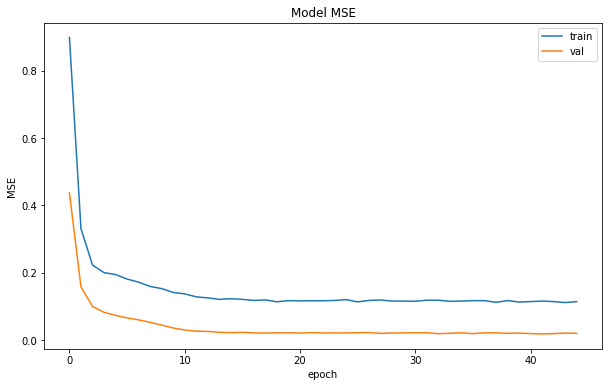

In [30]:
# plot accuracy and loss for the test set
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model MSE')
ax.set_ylabel('MSE')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='best')


R2 Latitude Teste - 0.9774994853717341
R2 Longitude Teste - 0.9803465573860067
R2 Total Teste - 0.9789230213788704


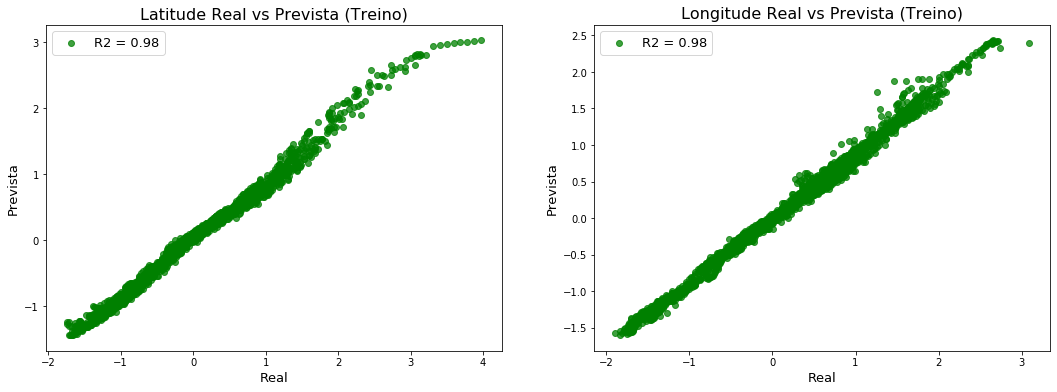

In [62]:
from sklearn.metrics import r2_score
ypred = model.predict(xtest)
# from sklearn.linear_model import LinearRegression
# lr = LinearRegression().fit(ytest,ypred)
# lr.score(ytest,ypred)
lat_r2 = r2_score(ytest[:,0],ypred[:,0])
lon_r2 = r2_score(ytest[:,1],ypred[:,1])
tot_r2 = r2_score(ytest,ypred)
print(f"R2 Latitude Teste - {lat_r2}")
print(f"R2 Longitude Teste - {lon_r2}")
print(f"R2 Total Teste - {tot_r2}")

fig, (ax,ax1) = plt.subplots(1,2,figsize=(18,6))
ax.set_title("Latitude Real vs Prevista (Treino)",fontsize=16)
ax.set_xlabel("Real",fontsize = 13)
ax.set_ylabel("Prevista",fontsize = 13)
ax.scatter(ytest[:,0],ypred[:,0],alpha = 0.75, color = 'g',label = f"R2 = {round(lat_r2,2)}")
ax.legend(loc='best', fontsize = 13)
ax1.set_title("Longitude Real vs Prevista (Treino)",fontsize=16)
ax1.set_xlabel("Real",fontsize = 13)
ax1.set_ylabel("Prevista",fontsize = 13)
ax1.scatter(ytest[:,1],ypred[:,1],alpha = 0.75, color = 'g',label = f"R2 = {round(lon_r2,2)}")
ax1.legend(loc='best', fontsize = 13);

In [71]:
data_test = data.loc[int(n*0.9):,:]
data_test.loc[:,'Hours'] = (data_test.loc[:,'Time_new']-pd.Timestamp(1951,1,1))/pd.Timedelta('1 hour')
# data_test[data_test.Category=="Category 3"]
irene = data_test[data_test.ID=='AL092011']
irene.loc[:,['Hours','Latitude','Longitude','Maximum Wind']]=standard_scale(irene,['Hours','Latitude','Longitude','Maximum Wind'])
ir = irene.loc[:,['Hours','Latitude','Longitude','Maximum Wind']]

def predict(storm,model,shift=3,pred=1):
    storm = storm.set_index(np.arange(0,len(storm)))
    y_pred=[]
    for i in range(0,len(storm)-shift-1):
        x = []
        for j in range(i,i+shift):
            x.append(storm.loc[j,:])
#         if i == 0:
#             print(np.expand_dims(np.asarray(x), axis=0).shape)
#             print(np.expand_dims(np.asarray(x),axis=0)[0,0,0])
        y_pred.append(model.predict(np.expand_dims(np.asarray(x),axis=0)).ravel())
        del x
    return np.array(y_pred)
y_pred = predict(ir,model)
y_pred.shape

(39, 2)

In [65]:
# def calculate_r2(test_storms,model,shift=3,pred=1,input_cols=['Hours','Latitude','Longitude','Maximum Wind']):
#     r2_lat = []
#     r2_lon = []
    
#     for s in test_storms:
#         s = s.set_index(np.arange(0,len(s)))
#         s.loc[:,input_cols] = min_max_scale(s,input_cols)
#         name = s.ID[0]
# #         print("Processing {}".format(name))
#         s = s[input_cols]
#         ypred = predict(s,model,shift,pred)
#         r2_lat.append(r2_score(s.iloc[0:-shift-1,:].Latitude,ypred[:,0]))
#         r2_lon.append(r2_score(s.iloc[0:-shift-1,:].Longitude,ypred[:,1]))
# #         print("Done with {}".format(name))
#     return r2_lat,r2_lon
# test_storms = split(data_test.set_index(np.arange(0,len(data_test))))

In [1]:
# r2_lat,r2_lon = calculate_r2(test_storms,model)

In [2]:
# plt.hist(r2_lat)
# np.mean(r2_lat),np.mean(r2_lon)

0.9222552427783463
0.8272646818195059


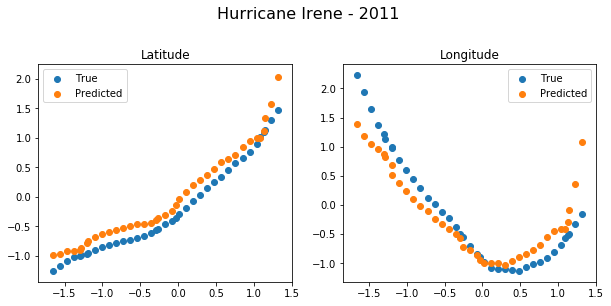

In [72]:
ir_plot = ir.iloc[0:-4,:]
fig,ax = plt.subplots(1,2,figsize=(10,4))
fig.suptitle("Hurricane Irene - 2011", fontsize=16,y=1.08)
ax[0].set_title("Latitude")
ax[1].set_title("Longitude")
print(r2_score(ir_plot.Latitude,y_pred[:,0]))
print(r2_score(ir_plot.Longitude,y_pred[:,1]))
ax[0].scatter(ir_plot.Hours,ir_plot.Latitude,label = 'True')
ax[0].scatter(ir_plot.Hours,y_pred[:,0],label = 'Predicted')
ax[1].scatter(ir_plot.Hours,ir_plot.Longitude,label = 'True')
ax[1].scatter(ir_plot.Hours,y_pred[:,1],label = 'Predicted')
ax[0].legend(loc='best')
ax[1].legend(loc='best')

In [74]:
input_cols = ['Hours','Latitude','Longitude','Maximum Wind']
joaquin = data_test[data_test.ID=='AL112015']
joaquin.loc[:,input_cols]=standard_scale(joaquin,input_cols)
y_jq = predict(joaquin[input_cols],model)

0.9623304852715133
0.9727193888243539


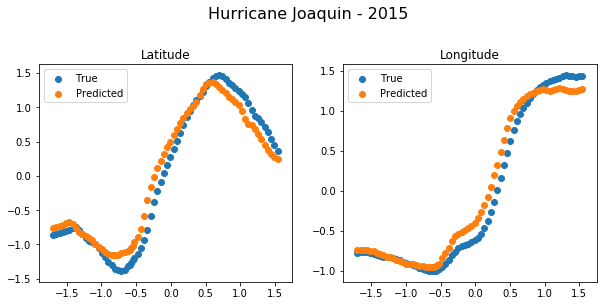

In [75]:
jq_plot = joaquin[input_cols].iloc[0:-4,:]
fig,ax = plt.subplots(1,2,figsize=(10,4))
fig.suptitle("Hurricane Joaquin - 2015", fontsize=16,y=1.08)
ax[0].set_title("Latitude")
ax[1].set_title("Longitude")
print(r2_score(jq_plot.Latitude,y_jq[:,0]))
print(r2_score(jq_plot.Longitude,y_jq[:,1]))
ax[0].scatter(jq_plot.Hours,jq_plot.Latitude,label = 'True')
ax[0].scatter(jq_plot.Hours,y_jq[:,0],label = 'Predicted')
ax[1].scatter(jq_plot.Hours,jq_plot.Longitude,label = 'True')
ax[1].scatter(jq_plot.Hours,y_jq[:,1],label = 'Predicted')
ax[0].legend(loc='best')
ax[1].legend(loc='best')

0.97188320744126
0.8193950513495228


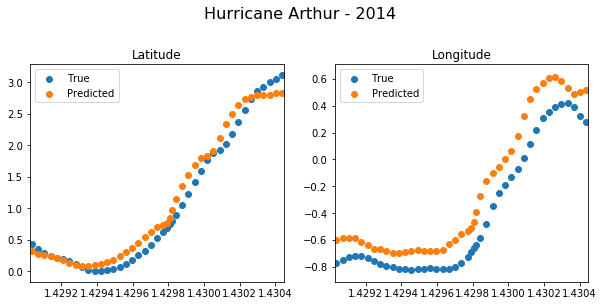

In [76]:
arthur = test_storms[50][input_cols]
y_art = predict(arthur,model)
art_plot = arthur.iloc[0:-4,:]
fig,ax = plt.subplots(1,2,figsize=(10,4))
fig.suptitle("Hurricane Arthur - 2014", fontsize=16,y=1.08)
ax[0].set_title("Latitude")
ax[1].set_title("Longitude")
print(r2_score(art_plot.Latitude,y_art[:,0]))
print(r2_score(art_plot.Longitude,y_art[:,1]))
ax[0].scatter(art_plot.Hours,art_plot.Latitude,label = 'True')
ax[0].scatter(art_plot.Hours,y_art[:,0],label = 'Predicted')
ax[0].set_xlim(min(art_plot.Hours)-0.00001,max(art_plot.Hours)+0.00001)
ax[1].scatter(art_plot.Hours,art_plot.Longitude,label = 'True')
ax[1].scatter(art_plot.Hours,y_art[:,1],label = 'Predicted')
ax[1].set_xlim(min(art_plot.Hours)-0.00001,max(art_plot.Hours)+0.00001)
ax[0].legend(loc='best')
ax[1].legend(loc='best')

In [54]:
len(train_storms),len(test_storms),len(val_storms)

(479, 69, 137)